In [1]:
import numpy as np
import nltk
import string
import os
import pandas
import matplotlib.pyplot as plt
import profanityfilter
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from scipy.interpolate import interp1d

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pandas.read_csv('merged.csv')
df_sorted = df.sort(['Year'], ascending=[1])
print(df_sorted.shape)
print(df_sorted.head())

(4988, 4)
                                          Song           Artist  Year  \
0     i cant help myself sugar pie honey bunch        four tops  1965   
4109                           it aint me babe      the turtles  1965   
4110                 red roses for a blue lady         vic dana  1965   
4111                     dont just stand there       patty duke  1965   
4112                             little things  bobby goldsboro  1965   

                                                 Lyrics  
0      Ooh, sugar pie, honey bunch\nYou know that I ...  
4109   go away from my window leave at your own chos...  
4110  vic dana miscellaneous red roses for a blue la...  
4111  please dont just stand there come and kiss me ...  
4112  little things that you do  make me glad im in ...  


/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


R2 score: 0.26493386708


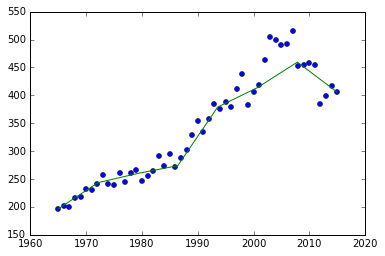

In [3]:
### Benchmark Model

# Count the number of words in each song
word_counts = [len(row[1]['Lyrics'].replace('\n', ' ').split()) for row in df_sorted.iterrows()]
X_bench = np.array(word_counts).reshape((len(word_counts), 1))
y_bench = df_sorted['Year']

# Train test split for benchmark
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.2, random_state=1)

# Initiliaze and train the benchmar model
benchmark_model = LinearRegression()
benchmark_model.fit(X_train_b, y_train_b)

# Predict year using the benchmark and print r2 score
y_pred = benchmark_model.predict(X_test_b)
print('R2 score: {}'.format(r2_score(y_test_b, y_pred)))

# Plot word count average per year
aggregations = {'Lyrics': lambda x: np.mean([len(r.replace('\n', ' ').split()) for r in x])}

word_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
x = range(1965, 2016)

# Interpolate the function
f = interp1d(np.array(x), np.array(word_count_avg_per_year).squeeze(), kind='cubic')
x_interp = np.linspace(1965, 2015, num=8, endpoint=True)

# Plot
plt.plot(x, word_count_avg_per_year, 'o', x_interp, f(x_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()



In [4]:
### Vectorizing the data

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens_filtered = filter(lambda w: not w in set(stopwords.words('english')), tokens)
    stems = stem_tokens(tokens_filtered, stemmer)
    return stems

result = []

for row in df.iterrows():
    text = row[1]['Lyrics']
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    result.append(no_punctuation)

try:
    tfs = pickle.load(open("tfs.pickle", "rb"))
except (OSError, IOError) as e:
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', encoding='latin-1', binary=True, sublinear_tf=True)
    tfs = tfidf.fit_transform(result)
    pickle.dump(tfs, open("tfs.pickle", "wb"))

tfs.shape

(4988, 22637)

In [5]:
### Adding relevant features
profanityfilter.append_words(['skeet', 'hoe', 'hoes', 'thot', 'thots', 'niggas', 'niggaz', 'shits', 'mothafuckin'])

# Compute profanity count average per year
aggregations = {
    'Lyrics': lambda year: np.mean([sum([r.replace('\n', ' ').lower().translate(None, string.punctuation).split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in year])
}

try:
    profanity_count_avg_per_year = pickle.load(open("pcapy.pickle", "rb"))
except (OSError, IOError) as e:
    profanity_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
    pickle.dump(profanity_count_avg_per_year, open("pcapy.pickle", "wb"))

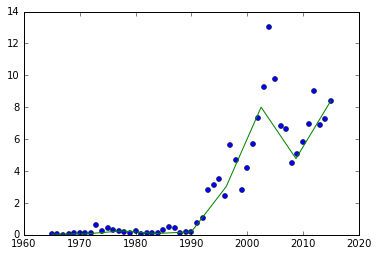

In [6]:
# Interpolate the function
f_prof = interp1d(np.array(x), np.array(profanity_count_avg_per_year).squeeze(), kind='cubic')
x_prof_interp = np.linspace(1965, 2015, num=9, endpoint=True)

# Plot profanity average per year
plt.plot(x, profanity_count_avg_per_year, 'o', x_prof_interp, f_prof(x_prof_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()

In [7]:
# profanity_count = [sum([r.split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in result]
profanity_exists = [1 if any([p in r.split() for p in profanityfilter.get_bad_words()]) else 0 for r in result]

In [21]:
tfs_profanity = np.concatenate((np.array(profanity_exists).reshape(len(profanity_exists), 1), tfs.toarray()), axis=1)
print('Dataset with profanity: {}\n'.format(tfs_profanity.shape))
word_count_per_dp = [len(r.replace('\n', ' ').split()) for r in df['Lyrics']]

tfs_profanity_wc = np.concatenate((np.array(word_count_per_dp).reshape(len(word_count_per_dp), 1), tfs_profanity), axis=1)
print('Dataset with profanity and word count shape: {}\n'.format(tfs_profanity_wc.shape))

X_train, X_test, y_train, y_test = train_test_split(tfs_profanity_wc, df['Year']-1965, test_size=0.2, random_state=2)
print('y_train samples:')
print(y_train.head())

Dataset with profanity: (4988, 22638)

Dataset with profanity and word count shape: (4988, 22639)

y_train samples:
3526    45
1847    25
3418    43
2604    34
3643    46
Name: Year, dtype: int64


In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=0)
pca.fit(tfs_profanity_wc)

print(pca.explained_variance_ratio_)

[  9.99962362e-01   4.31339564e-06   2.21085750e-07   1.41930511e-07
   1.09362879e-07   8.93347986e-08   8.64791621e-08   7.97219445e-08
   7.69079600e-08   7.36684701e-08   7.11823731e-08   6.95490464e-08
   6.78740668e-08   6.57102534e-08   6.42749355e-08   6.41822411e-08
   6.33105627e-08   6.23486649e-08   6.22218736e-08   6.09073596e-08
   6.00503357e-08   5.94946722e-08   5.91537428e-08   5.85379508e-08
   5.77966472e-08   5.71370817e-08   5.66031614e-08   5.56755471e-08
   5.53973662e-08   5.49266517e-08   5.40145316e-08   5.36739964e-08
   5.31392124e-08   5.28820910e-08   5.21465799e-08   5.19622654e-08
   5.17104855e-08   5.16637654e-08   5.12971488e-08   5.09744153e-08
   5.08235947e-08   4.98616624e-08   4.96373644e-08   4.94036738e-08
   4.90397168e-08   4.84411805e-08   4.80549001e-08   4.79125455e-08
   4.76473852e-08   4.70724629e-08]


In [43]:
print(tfs_profanity_wc)
print(pca.n_components_)
tfs_post_pca = pca.transform(tfs_profanity_wc)

X_train, X_test, y_train, y_test = train_test_split(tfs_post_pca, df['Year']-1965, test_size=0.2, random_state=2)

rf = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=300, max_features=20, verbose=2)
rf.fit(X_train, y_train)
print(rf.feature_importances_)

[[ 277.    0.    0. ...,    0.    0.    0.]
 [ 256.    0.    0. ...,    0.    0.    0.]
 [ 156.    0.    0. ...,    0.    0.    0.]
 ..., 
 [ 509.    1.    0. ...,    0.    0.    0.]
 [ 500.    1.    0. ...,    0.    0.    0.]
 [ 223.    0.    0. ...,    0.    0.    0.]]
50
building tree 1 of 300
building tree 2 of 300building tree 3 of 300

building tree 4 of 300
building tree 5 of 300 building tree 6 of 300
building tree 7 of 300

building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300 building tree 16 of 300

building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tre

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.0s


building tree 41 of 300
building tree 40 of 300
building tree 42 of 300
building tree 43 of 300
building tree 46 of 300building tree 44 of 300
building tree 45 of 300

building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300 building tree 78 of 300

building tree 79 of 300
building tree 80 of 300
building tree 8

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.3s


building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.9s finished


[ 0.24580056  0.11775572  0.02261215  0.02282315  0.01718015  0.01565229
  0.03276508  0.01359934  0.01591128  0.01115445  0.01267975  0.01026318
  0.02539569  0.02927914  0.00988467  0.01313687  0.01195593  0.01324102
  0.01089845  0.01156719  0.0136406   0.01090242  0.01107598  0.01941047
  0.01041338  0.01076688  0.0102405   0.01125189  0.01072794  0.01159518
  0.01127889  0.01080916  0.01048025  0.00979251  0.01088052  0.0117471
  0.01113031  0.01036071  0.01171354  0.01103037  0.0107862   0.01109842
  0.01158577  0.01053418  0.01032946  0.01020111  0.01019893  0.00998337
  0.01178766  0.01069021]


In [44]:
rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.7s finished


0.46324752976695094

In [80]:
nn = MLPRegressor(verbose=True, random_state=1, hidden_layer_sizes=(50,), alpha=0.0001, validation_fraction=0.2)

In [81]:
nn.fit(X_train, y_train)

Iteration 1, loss = 1742.78846911
Iteration 2, loss = 745.32051079
Iteration 3, loss = 347.01342199
Iteration 4, loss = 237.13485484
Iteration 5, loss = 222.84565660
Iteration 6, loss = 221.60883035
Iteration 7, loss = 221.02137019
Iteration 8, loss = 220.44736107
Iteration 9, loss = 219.88814010
Iteration 10, loss = 219.33325663
Iteration 11, loss = 218.72080039
Iteration 12, loss = 218.02489088
Iteration 13, loss = 217.42820981
Iteration 14, loss = 216.71466790
Iteration 15, loss = 216.04122681
Iteration 16, loss = 215.34318408
Iteration 17, loss = 214.64500771
Iteration 18, loss = 213.92289611
Iteration 19, loss = 213.16850925
Iteration 20, loss = 212.50501294
Iteration 21, loss = 211.68643407
Iteration 22, loss = 210.89943812
Iteration 23, loss = 210.31261979
Iteration 24, loss = 209.51558573
Iteration 25, loss = 208.90198288
Iteration 26, loss = 207.87166028
Iteration 27, loss = 206.89184970
Iteration 28, loss = 206.04020270
Iteration 29, loss = 205.27857747
Iteration 30, loss = 2

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.2, verbose=True,
       warm_start=False)

In [82]:
nn.score(X_test, y_test)

0.46644313957765082